In [1]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

In [2]:
NSIDE = 512
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)

Approximate resolution at NSIDE 512 is 0.11 deg


In [3]:
NPIX = hp.nside2npix(NSIDE)
print(NPIX)

3145728


In [4]:
m = np.arange(NPIX)
m

array([      0,       1,       2, ..., 3145725, 3145726, 3145727],
      shape=(3145728,))

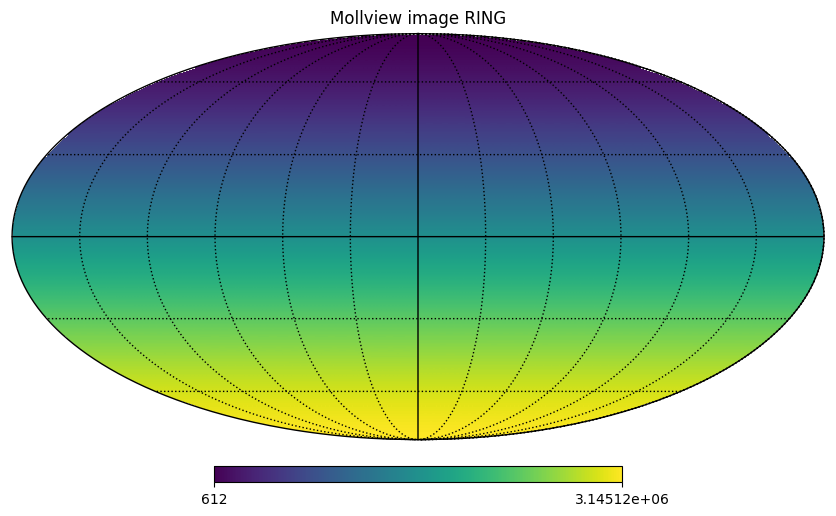

In [5]:
hp.mollview(m, title="Mollview image RING")
hp.graticule()

In [22]:
wmap_map_I = hp.read_map("wmap_band_iqumap_r9_7yr_Ka_v4.fits")

In [7]:
len(wmap_map_I)

3145728

In [24]:
nside_original = hp.get_nside(wmap_map_I)
print(f"Original NSIDE: {nside_original}")

Original NSIDE: 512


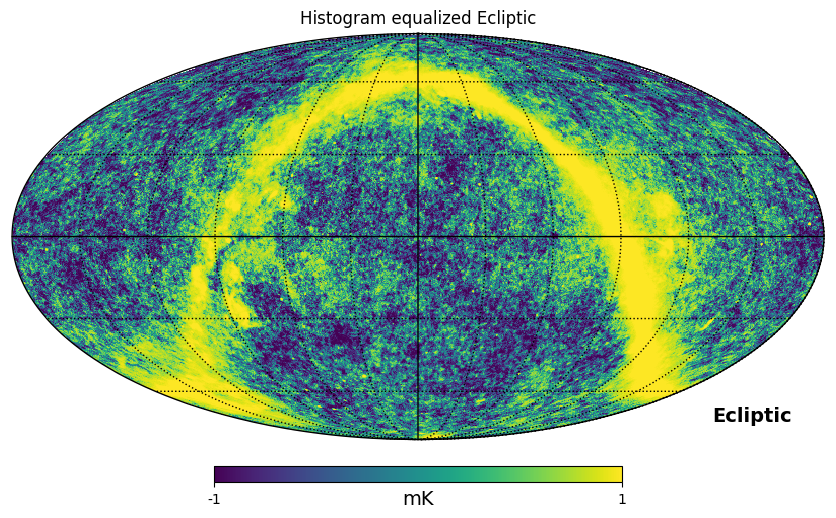

In [29]:
hp.mollview(
    wmap_map_I,
    coord=["G", "E"],
    title="Histogram equalized Ecliptic",
    unit="mK",
    norm="hist",
    min=-1,
    max=1,
)
hp.graticule()

### Step to take:
- Use wmap_map_I array instead of image
- Check if it's possible to map the image to a matrix array (squared image). For this, it is important to understand the structure of the wmap array
- apply codec to compress a .aqmp file
- load the .aqmp file and reverse the transform to get back a wmap, or a .png if wanted.

In [36]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

wmap_map_I = hp.read_map("wmap_band_iqumap_r9_7yr_Ka_v4.fits")

resolution = 512

# Define longitude and latitude grid
lon = np.linspace(-180, 180, resolution)
lat = np.linspace(-90, 90, resolution)
lon, lat = np.meshgrid(lon, lat)

# Transform the HEALPix map to a Cartesian projection to obtain the 2D image array
projected_map = hp.cartview(
    wmap_map_I,
    coord=["G", "E"],
    title="Histogram equalized Ecliptic",
    unit="mK",
    norm="hist",
    min=-1,
    max=1,
    xsize=resolution,
    return_projected_map=True,
    cbar=False,  # Remove the colorbar
    notext=True,
)
# Use Matplotlib to fine-tune the figure
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove all margins
plt.axis("off")  # Remove axes
plt.title("")
plt.savefig("wmap_projected.png", bbox_inches="tight", pad_inches=0)
plt.close()

In [33]:
wmap_map_I.shape[0]/2048

1536.0

In [34]:
projected_map.shape

(256, 512)

In [4]:
from aqmp import ImageCompressor
import warnings
from skimage import io, img_as_float
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from PIL import Image

In [49]:
min_sparcity = 40
min_n = 2**2
max_n = 2**4
a_cols = 256
max_error = 0.001

newCodec = ImageCompressor(
                           min_sparcity,
                           min_n,
                           max_n,
                           a_cols,
                           max_error
                          )
input_file = 'wmap_projected.png'
output_file = 'wmap_projected.aqmp'

newCodec.encode(input_file, output_file)

processed_blocks: 2970
bytes_written (without DEFLATE): 1804681
File saved.


In [50]:
input_file = 'wmap_projected.aqmp'
output_file = 'wmap_projected_recontructed.png'

newCodec.decode(input_file, output_file)

Output file saved to: wmap_projected_recontructed.png


# Transform coordinates directly to cartesian

In [70]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

# Load the HEALPix map
wmap_map_I = hp.read_map("wmap_band_iqumap_r9_7yr_Ka_v4.fits")

# Define resolution for the square matrix
resolution = 512
square_map = np.zeros((resolution, resolution))  # Initialize square matrix

# Define the Cartesian grid
x = np.linspace(-1, 1, resolution)  # X-axis in Cartesian coordinates
y = np.linspace(-1, 1, resolution)  # Y-axis in Cartesian coordinates
xx, yy = np.meshgrid(x, y)  # Create 2D grid

# Convert Cartesian to spherical (galactic) coordinates
r = np.sqrt(xx**2 + yy**2)  # Radius in the xy-plane
mask = r <= 1  # Mask points outside the unit sphere
valid_xx = xx[mask]  # Masked Cartesian x-coordinates
valid_yy = yy[mask]  # Masked Cartesian y-coordinates

# Compute spherical coordinates for valid points
theta = np.arccos(np.sqrt(1 - valid_xx**2 - valid_yy**2))  # Polar angle (latitude)
phi = np.arctan2(valid_yy, valid_xx)  # Azimuthal angle (longitude)
phi[phi < 0] += 2 * np.pi  # Ensure phi is in [0, 2*pi]

# Map spherical coordinates to HEALPix pixel indices
nside = hp.get_nside(wmap_map_I)  # Get NSIDE of the original map
pixels = hp.ang2pix(nside, theta, phi)  # Map angles to HEALPix pixel indices

# Fill the square matrix with HEALPix values
square_map[mask] = wmap_map_I[pixels]



In [71]:
square_map[mask] = wmap_map_I[pixels]

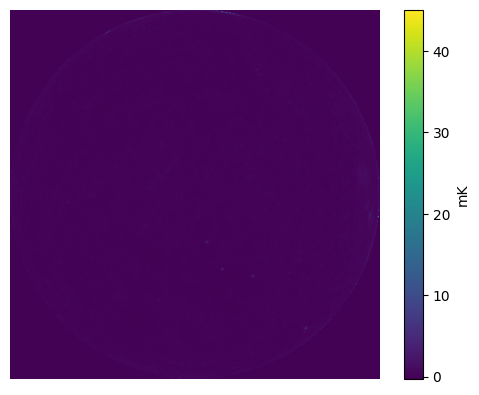

In [72]:
# Visualize the square matrix
plt.imshow(square_map, origin="lower", extent=[-1, 1, -1, 1], cmap="viridis")
plt.colorbar(label="mK")
plt.axis("off")
plt.savefig("wmap_square_projection.png", bbox_inches="tight", pad_inches=0)
plt.show()

In [73]:
wmap_map_I[pixels]

array([2.5979216, 5.9272966, 1.0331824, ..., 2.5120182, 2.9698415,
       7.09282  ], dtype='>f4')

In [74]:
wmap_map_I

array([-0.04047656, -0.0839029 , -0.06307314, ...,  0.04648832,
       -0.01735104, -0.04667021], dtype='>f4')